In [1]:
import os
import asyncio
import logging
from dotenv import load_dotenv
from pydantic import BaseModel, Field
from typing import Annotated, Dict, Literal, Sequence, TypedDict, List
from qdrant_client import QdrantClient
from langchain_qdrant import QdrantVectorStore
from langchain import hub
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage
from langchain_core.prompts import PromptTemplate
from langchain_core.tools import tool
from langchain.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain.tools.retriever import create_retriever_tool
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.graph.message import add_messages
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import ToolNode, tools_condition, InjectedState
from langgraph.checkpoint.memory import MemorySaver

load_dotenv()
logging.basicConfig(
    level=logging.INFO,
    # level=None,
    format="%(asctime)s - %(levelname)s - %(message)s",
)

search_limit = 5
client_id = "client123"
datasource_id = "source_456"

### Create agent state

class AgentState(TypedDict):
    # The add_messages function defines how an update should be processed
    # Default is to replace. add_messages says "append"
    messages: Annotated[Sequence[BaseMessage], add_messages]
    documents: List[str]
    question: str
    rewrite_count: int
    channel: str
    user_data: Dict[str, any]

### Retrever
embeddings = OpenAIEmbeddings()

# Add to vectorDB
client = QdrantClient(os.getenv("QDRANT_URL", "http://qdrant:6333"))
vectorstore = QdrantVectorStore(
    client,
    collection_name=os.getenv("QDRANT_COLLECTION", "test_collection"),
    embedding=embeddings
)
retriever = vectorstore.as_retriever(
    search_kwargs={
        "k": search_limit,
        "filter": {
            "must": [
                {"key": "metadata.client_id", "match": {"value": client_id}},
                {"key": "metadata.datasource_id", "match": {"value": datasource_id}}
            ]
        }
    }
)

### Create tools
@tool
def auth_tool() -> str:
    """
    Сall authorization function

    Returns:
        str: Trigger to call external authorization function.
    """
    return "необходима авторизация. Допиши в ответе: [AUTH_REQUIRED]"

@tool
def get_user_info_tool(state: Annotated[dict, InjectedState]) -> str:
    """
    Obtaining information about the user, his phone number, first name,
    last name, authorization status and the channel through which the user communicates.

    Args:
        state (chanel): the channel (messenger) through which the user communicates.
        state (user_data): user data (phone number, first name, last name, authorization status).

    Returns:
        dict: information about the user.
    """
    channel = state["channel"]
    if state["user_data"].get("is_authenticated"):
        user_fname = state["user_data"].get("first_name")
        user_lname = state["user_data"].get("last_name")
        user_phone = state["user_data"].get("phone_number")
        user_id = state["user_data"].get("user_id")

        return f"""Информация о пользователе:\n
                First Name : {user_fname}\n
                Last Name: {user_lname}\n
                User phone number: {user_phone}\n
                User ID: {user_id}\n
                User messenger: {channel}"""
    else:
        return f"User messenger: {channel}. Информация о пользователе недоступна без авторизации. Запусти авторизацию"

retriever_tool = create_retriever_tool(
    retriever,
    "retrieve_datastore",
    "Поиск и возврат информации о стиральной машине, ее возможностях, функциях, обслуживанию и рекомендациям по стирке",
    document_separator = "\n---RETRIEVER_DOC---\n",
)
datastore_tool = [retriever_tool]
safe_tools = [
    TavilySearchResults(max_results=3),
    auth_tool,
    get_user_info_tool,
    ]
datastore_tool_names = {t.name for t in datastore_tool} #  {'retrieve_datastore'} 
tools = datastore_tool + safe_tools

### Create Nodes

async def agent(state):
    """
    Invokes the agent model to generate a response based on the current state. Given
    the question, it will decide to retrieve using the retriever tool, or simply end.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with the agent response appended to messages
    """
    logging.info("---CALL AGENT---")
    messages = state["messages"]

    # Prompt
    prompt = ChatPromptTemplate.from_messages([
        ("system", 
         """Тебя зовут Сергей, ты менеджер в компании Рога и Копыта. 
         Твоя задача помогать клиенту в решении его опросов, консультировать используя данные в базе знаний.
         Если намерение клиента не ясно или не содержит ключевых слов, ты можешь запросить уточнение.
         Старайся отвечать кратко и содержательно.
         Перед ответом всегда обращайся к хранилищу данных."""),
        MessagesPlaceholder(variable_name="messages")
    ])

    model = ChatOpenAI(temperature=0, streaming=True, model="gpt-4o-mini")
    model = model.bind_tools(tools)

    chain = prompt | model
    response = await chain.ainvoke(messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}

async def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (messages): The current state

    Returns:
        str: A decision for whether the documents are relevant or not
    """

    logging.info("---CHECK RELEVANCE---")

    # Data model
    class grade(BaseModel):
        """Binary score for relevance check."""

        binary_score: str = Field(
            description="Relevance score 'yes' or 'no'"
            )

    messages = state["messages"]

    rewrite_count = state.get("rewrite_count", 0)
    last_message = messages[-1]
    docs = last_message.content.split("\n---RETRIEVER_DOC---\n")

    if rewrite_count == 0:
        logging.info("---FIRST TIME QUESTION---")
        question = messages[-3].content
        
    else:
        logging.info("---REWRITE QUESTION COUNT: ", rewrite_count)
        question = state["question"]

    # Prompt
    prompt = PromptTemplate(
        template="""Вы оцениваете релевантность извлеченного документа для вопроса пользователя. \n
                Вот извлеченный документ: \n\n {context} \n\n
                Вот вопрос пользователя: {question} \n
                Если документ содержит ключевые слова или семантическое значение, связанные с вопросом пользователя, оцените его как релевантный. \n
                Дайте двоичную оценку 'yes' или 'no', чтобы указать, соответствует ли документ вопросу.""",
        input_variables=["context", "question"],
    )

    # LLM
    model = ChatOpenAI(temperature=0, model="gpt-4o-mini")
    # LLM with tool and validation
    llm_with_tool = model.with_structured_output(grade)

    async def process_doc(doc):
        chain = prompt | llm_with_tool
        try:
            scored_result = await chain.ainvoke({"question": question, "context": doc})
            logging.info(f"Scored result: {scored_result.binary_score}")
            return doc, scored_result.binary_score
        except Exception as e:
            logging.info(f"Error processing document: {e}")
            return doc, "no"

    filtered_docs = []
    tasks = [process_doc(d) for d in docs]
    results = await asyncio.gather(*tasks)
    filtered_docs = [doc for doc, score in results if score == "yes"]

    return {"documents": filtered_docs, "question": question}

async def rewrite(state):
    """
    Transform the query to produce a better question.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with re-phrased question
    """

    logging.info("---TRANSFORM QUERY---")
    max_rewrites = 3
    question = state["question"]
    messages = state["messages"]
    rewrite_count = state.get("rewrite_count", 0)

    msg = [
        HumanMessage(
            content=f""" \n 
    Посмотрите на входные данные и попытайтесь рассуждать о лежащем в их основе семантическом
    намерении/значении исходя из контекста диалога, если он есть. \n
    Вот начальный вопрос:
    \n ------- \n
    {question} 
    \n ------- \n
    Вот контекст диалога:
    \n ------- \n
    {messages}
    \n ------- \n
    Сформулируйте улучшенный вопрос, без уточнений: """,
        )
    ]

    message_no_answer = "Ответ не найден. Попробуйте переформулировать вопрос."
    message_to_research = "Произведи поиск в базе данных заново. "

    # Grader
    model = ChatOpenAI(temperature=0, model="gpt-4o-mini", streaming=True)

    if rewrite_count < max_rewrites:
        response = await model.ainvoke(msg)
        logging.info("Rewrite question =>> ", response.content)
        human_style_response = HumanMessage(content=message_to_research + response.content)
        logging.info("---DECISION: AGENT TO RETRIEVE---")
        return {"messages": [human_style_response], "rewrite_count": rewrite_count + 1, "question": response.content}

    else:
        logging.info("---DECISION: AGENT NO ANSWER---")
        rewrite_count = 0
        tool_message_no_answer = AIMessage(content=message_no_answer)
        return {"messages": [tool_message_no_answer], "rewrite_count": rewrite_count}
    
async def generate(state):
    """
    Generate answer

    Args:
        state (messages): The current state

    Returns:
         dict: The updated state with re-phrased question
    """
    logging.info("---GENERATE---")
    messages = state["messages"]
    # question = messages[-3].content
    question = state["question"]
    # last_message = messages[-1]
    # docs = last_message.content

    docs = state["documents"]
    documents = "\n".join(docs)

    # Prompt
    # prompt = hub.pull("rlm/rag-prompt")
    prompt = PromptTemplate(
        template="""Ты помощник для задач с ответами на вопросы. Используйте следующие фрагменты извлеченного контекста, чтобы ответить на вопрос.
        Если у тебя нет ответа на вопрос, просто скажи что у тебя нет данных для ответа на этот вопрос, предложи переформулировать фопрос.
        Старайся отвечать кратко и содержательно.\n
        	Вопрос: {question} \n
        	Контекст: {context} \n
        	Ответ:""",
        input_variables=["context", "question"],
    )

    # LLM
    llm = ChatOpenAI(model_name="gpt-4o-mini", temperature=0, streaming=True)

    # Chain
    # rag_chain = prompt | llm | StrOutputParser()
    rag_chain = prompt | llm

    # Run
    response = await rag_chain.ainvoke({"context": documents, "question": question})
    return {"messages": [response]}

### Create Edges

async def decide_to_generate(state) -> Literal["generate", "rewrite"]:

    logging.info("---ASSESS GRADED DOCUMENTS---")
    filtered_documents = state["documents"]

    if not filtered_documents:
        logging.info(
            "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---"
        )
        return "rewrite"
    else:
        # We have relevant documents, so generate answer
        logging.info("---DECISION: GENERATE---")
        return "generate"
    
async def decide_to_end(state) -> Literal["end","rewrite", "agent"]:
    pass

async def route_tools(state: AgentState):
    next_node = tools_condition(state)
    # If no tools are invoked, return to the user
    if next_node == END:
        return END
    ai_message = state["messages"][-1]
    # This assumes single tool calls. To handle parallel tool calling, you'd want to
    # use an ANY condition
    first_tool_call = ai_message.tool_calls[0]
    if first_tool_call["name"] in datastore_tool_names:
        return "retrieve"
    return "safe_tools"

### Create Graph

# Define a new graph
workflow = StateGraph(AgentState)

# Define the nodes we will cycle between
workflow.add_node("agent", agent)  # agent
retrieve = ToolNode(datastore_tool)
safe_tools = ToolNode(safe_tools)
workflow.add_node("retrieve", retrieve)  # retrieval
workflow.add_node("safe_tools", safe_tools)  # tools
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("rewrite", rewrite)  # Re-writing the question
workflow.add_node("generate", generate)  # Generating a response after we know the documents are relevant

# Define the edges between the nodes
workflow.add_edge(START, "agent") # Call agent node to decide to retrieve or not
workflow.add_edge("retrieve", "grade_documents")
workflow.add_edge("safe_tools", "agent")
workflow.add_edge("rewrite", "agent")
workflow.add_edge("generate", END)

# Add conditional edges
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "rewrite": "rewrite",
        "generate": "generate",
    },
)
workflow.add_conditional_edges(
    "agent", route_tools, ["safe_tools", "retrieve", END]
)
# workflow.add_conditional_edges(
#     "agent",
#     tools_condition,
#     {
#         "tools": "retrieve",
#         END: END,
#     },
# )

# Add memory saver
memory = MemorySaver()
# Compile the graph
app = workflow.compile(checkpointer=memory)


2025-03-26 14:58:20,861 - INFO - HTTP Request: GET http://127.0.0.1:6333 "HTTP/1.1 200 OK"
2025-03-26 14:58:20,882 - INFO - HTTP Request: GET http://127.0.0.1:6333/collections/platformai "HTTP/1.1 200 OK"
2025-03-26 14:58:25,031 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


/Users/jb/Projects/experiments/.venv/lib/python3.12/site-packages/pydantic/_internal/_generate_schema.py:502: UserWarning: <built-in function any> is not a Python type (it may be an instance of an object), Pydantic will allow any object with no validation since we cannot even enforce that the input is an instance of the given type. To get rid of this error wrap the type with `pydantic.SkipValidation`.
  warn(


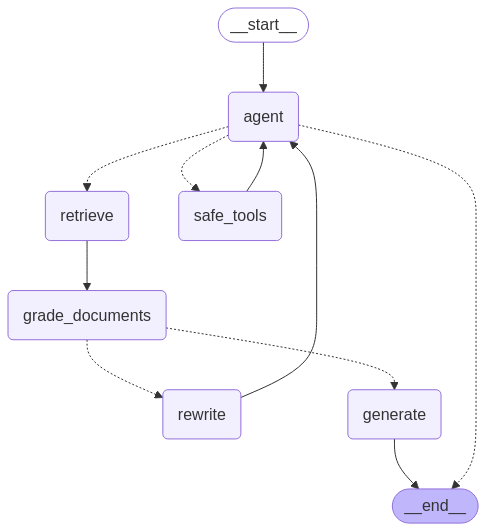

In [2]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [15]:
thread_id = 12345678
# query = "Поищи заново информацию в базе знаний. Сколько болтов в стиральной машине?"
query = "Авторизация"
# query = "Какие программы есть у машины?"
# query = "Сколько всего программ?"
# query = "Как стирать труханы?"
# query = "Как правильно стирать шелковые трусы?"

inputs = {
    "messages": [
        ("user", query),
    ]
}
config = {"configurable": {"thread_id": thread_id}}

async for output in app.astream(inputs, config, stream_mode="updates"):
    for key, value in output.items():
        print(f"Output from node '{key}':")
        print("---")
        print(value)
    print("\n---\n")

2025-03-25 23:11:45,128 - INFO - ---CALL AGENT---
2025-03-25 23:11:46,194 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-25 23:11:46,242 - INFO - ---CALL AGENT---


Output from node 'agent':
---
{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_tSinfVS6R3kECG88TJCOnhny', 'function': {'arguments': '{}', 'name': 'auth_tool'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_b8bc95a0ac'}, id='run-d2f305fc-d0f1-4c7f-bc14-34e20852f0c2-0', tool_calls=[{'name': 'auth_tool', 'args': {}, 'id': 'call_tSinfVS6R3kECG88TJCOnhny', 'type': 'tool_call'}])]}

---

Output from node 'safe_tools':
---
{'messages': [ToolMessage(content='необходима авторизация. Допиши в ответе: [AUTH_REQUIRED]', name='auth_tool', id='631757f9-f5d3-47cc-9efa-8309695d9cb6', tool_call_id='call_tSinfVS6R3kECG88TJCOnhny')]}

---



2025-03-25 23:11:47,147 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Output from node 'agent':
---
{'messages': [AIMessage(content='Для выполнения авторизации необходима дополнительная информация. Пожалуйста, предоставьте необходимые данные. [AUTH_REQUIRED]', additional_kwargs={}, response_metadata={'finish_reason': 'stop', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_b8bc95a0ac'}, id='run-24a0a2d6-23c2-4981-a9a9-8c6aa3bd7677-0')]}

---

